In [1]:
import numpy as np
import pandas as pd
import datetime
import pickle
import re

# LSTM
import keras
from keras.layers import Input, Embedding, LSTM, Dense
from keras.models import Model
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# 誤差の評価
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# グラフ描画
from matplotlib import pylab as plt
import seaborn as sns
%matplotlib inline
sns.set()

Using TensorFlow backend.


In [2]:
inputDir = "/home/onimem/work/Open_world/NBA/Graph"
outputDir = "/home/onimem/work/Open_world/NBA/Model"

# 時系列グラフの読み込み
with open(inputDir + '/nba.graph', mode='rb') as f:
    graph = pickle.load(f)

In [3]:
def is_unique(seq):
    return len(seq) == len(set(seq))

def new_node(y1nodes, y2nodes):
    if is_unique(y1nodes) and is_unique(y2nodes):
        newnodes = set(y2nodes) - set(y1nodes)
        return len(newnodes)
    else :
        print("error")
        exit()

def loss_node(y1nodes, y2nodes):
    if is_unique(y1nodes) and is_unique(y2nodes):
        lossnodes = set(y1nodes) - set(y2nodes)
        return len(lossnodes)
    else :
        print("error")
        exit()

def plot_history(history, x, y, title):
    plt.plot(history[x], history[y], marker=".", label=y, color='#1ea8b5')
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.legend()
    plt.show()
    
def plot_history2(history, x, y1, y2, title, ylabel):
    plt.plot(history[x], history[y1], marker=".", color='#1ea8b5', label=y1)
    plt.plot(history[x], history[y2], marker=".", color='#ce405f', label=y2)
    plt.title(title)
    plt.xlabel(x)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

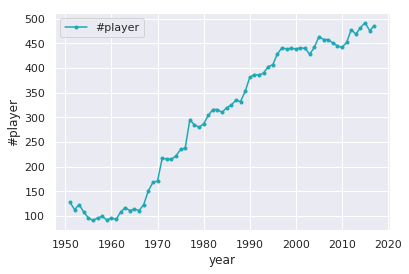

In [4]:
# NBA全体の競技人口をプロット
# 1950年データは異常値のため使用しない

x = "year"
years = [i for i in range(1951, 2018)]

y = "#player"
num_player = []
for year in years:
    num_player.append(len(graph[year]['nodes']))

history = {x:years, y:num_player}
plot_history(history, x, y, title="")


# graphデータ構造をactive teamでグルーピング : graph_tm
activeteam = ['ATL', 'BRK', 'BOS', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK', 'OKC', 'ORL', 'PHO', 'PHI', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS']

# graph per team
graph_tm = {}
for tm in activeteam:
    graph_tm[tm] = {}
    for year in years:
        graph_tm[tm][year] = {}
        for name, attribute in graph[year]['nodes'].items():
            if attribute["Tm"] == tm:
                graph_tm[tm][year][name] = graph[year]['nodes'][name]

In [5]:
# データ変換
def convert(X, ws = 1, dim = 1):
    data = []
    target = []
    
    for i in range(ws, len(X)):
        data.append(X[i - ws : i])
        target.append(X[i])
        
    # データの整形
    data = np.array(data).reshape(len(data), ws, dim)
    target = np.array(target).reshape(-1,1)
        
    return data, target

In [6]:
def Lstm(X_train_c, X_val_c, y_train_c, y_val_c):
    
    #モデル設定
    main_input = Input(shape=(X_train_c.shape[1], X_train_c.shape[2]),
                       dtype='float32',
                       batch_shape = (1, X_train_c.shape[1], 1), 
                       name='main_input')

    out = LSTM(8, stateful = True, return_sequences = True, activation='tanh')(main_input)
    out = LSTM(16, stateful = True, activation='tanh')(main_input)
    main_output = Dense(1, activation='linear', name='output')(out)
    
    model = Model(inputs=[main_input], outputs=[main_output])
    model.compile(loss="mse", optimizer=Adam())
    
    #学習
    batch_size = 1
    n_epoch = 1000
    
    log_loss = np.zeros(n_epoch)
    log_val_loss = np.zeros(n_epoch)
    models = []
    
    
    for i in range(n_epoch):
        res = model.fit(X_train_c, y_train_c, batch_size = batch_size, 
              epochs = 1, validation_data=(X_val_c, y_val_c), verbose = 0, shuffle = False)
        
        #lossを保存
        log_loss[i] = res.history['loss'][0]
        log_val_loss[i] = res.history['val_loss'][0]
        models.append(res)
        
        model.reset_states() #毎回stateをリセット
    
    loss_df = pd.DataFrame([log_loss, log_val_loss]).T
    loss_df.columns = ["loss", "val_loss"]
    #loss_df.plot()
    
    print(np.argsort(log_val_loss)[0])
    print(np.argsort(log_loss)[0])
    best_model = models[np.argsort(log_val_loss)[0]].model
    
    return best_model

In [7]:
#各予測に予測結果を使う
def predict(model, X, X_val):
    model.reset_states()

    length = len(X_val)
    prediction_train = np.zeros(len(X))
    prediction = np.zeros(length)
        
    #train分まず予測する
    for i in range(len(X)):
        prediction_train[i] = model.predict(X[i].reshape(1,-1,1))[0]
    
    tmp = X[len(X) - 1, :, :].reshape(1,-1,1)#学習データの最後の値から予測していく
    
    #特定期間さきまで予測
    for i in range(length):
        prediction[i] = model.predict(tmp)[0]
        
        #次に予測に使うデータを更新
        tmp = tmp[0, 1:, 0]
        tmp = np.append(tmp, prediction[i]).reshape(1,-1,1)
        #tmp = prediction[i].reshape(1,-1,1)
    
    model.reset_states()
    
    return np.hstack((prediction_train, prediction))

(53, 5, 1) (8, 5, 1) (53, 1) (8, 1)
855
984


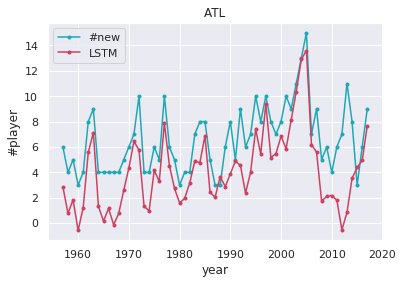

(28, 5, 1) (8, 5, 1) (28, 1) (8, 1)
1
998


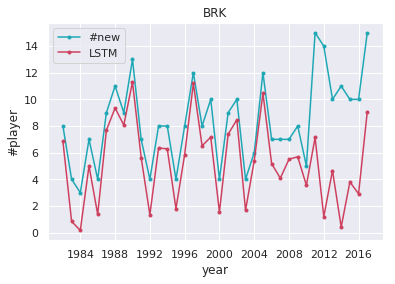

(53, 5, 1) (8, 5, 1) (53, 1) (8, 1)
636
932


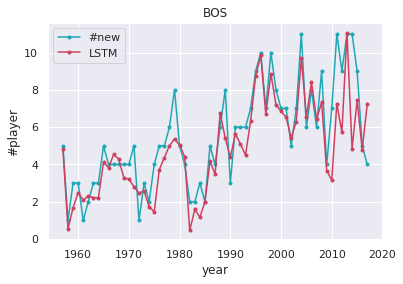

(14, 5, 1) (8, 5, 1) (14, 1) (8, 1)
109
923


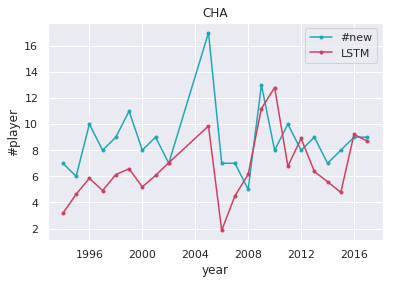

(38, 5, 1) (8, 5, 1) (38, 1) (8, 1)
987
925


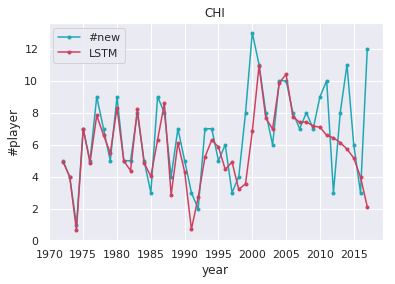

(34, 5, 1) (8, 5, 1) (34, 1) (8, 1)
881
992


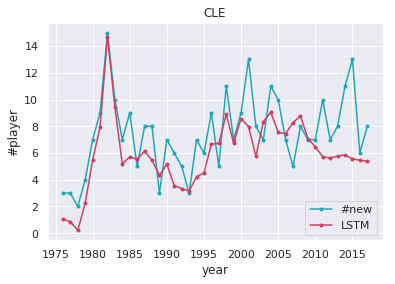

(24, 5, 1) (8, 5, 1) (24, 1) (8, 1)
85
752


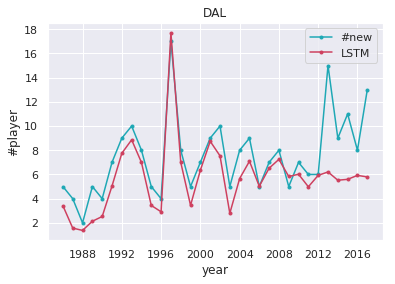

(28, 5, 1) (8, 5, 1) (28, 1) (8, 1)
622
628


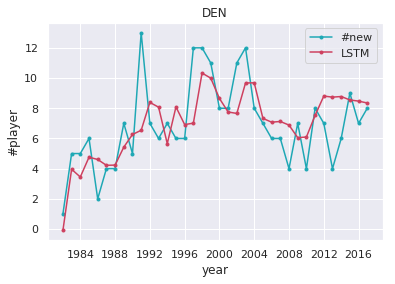

(53, 5, 1) (8, 5, 1) (53, 1) (8, 1)
839
685


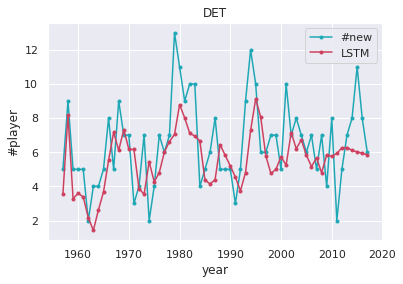

(53, 5, 1) (8, 5, 1) (53, 1) (8, 1)
302
830


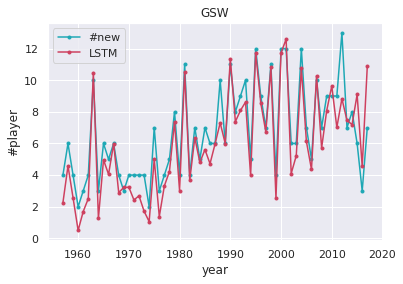

(37, 5, 1) (8, 5, 1) (37, 1) (8, 1)
949
627


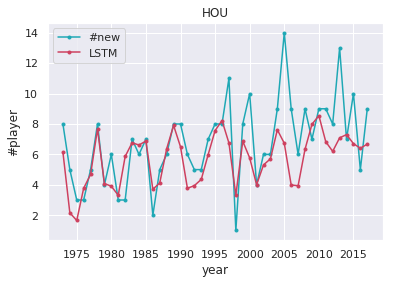

(28, 5, 1) (8, 5, 1) (28, 1) (8, 1)
878
894


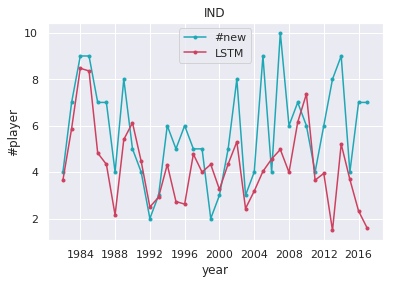

(34, 5, 1) (8, 5, 1) (34, 1) (8, 1)
65
932


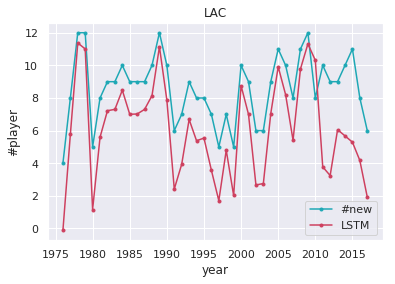

(53, 5, 1) (8, 5, 1) (53, 1) (8, 1)
192
998


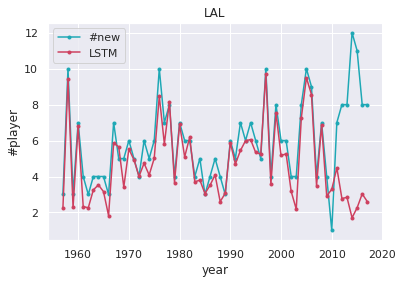

(9, 5, 1) (8, 5, 1) (9, 1) (8, 1)
707
930


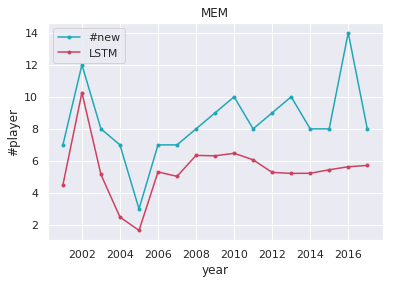

(15, 5, 1) (8, 5, 1) (15, 1) (8, 1)
1
814


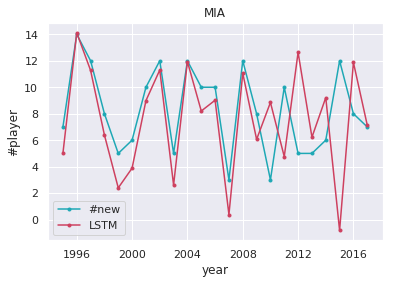

(36, 5, 1) (8, 5, 1) (36, 1) (8, 1)
136
982


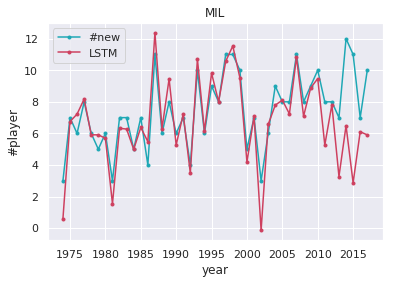

(15, 5, 1) (8, 5, 1) (15, 1) (8, 1)
4
900


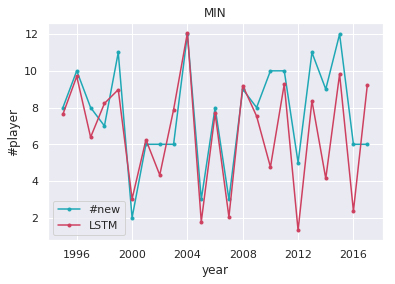

(2, 5, 1) (8, 5, 1) (2, 1) (8, 1)
18
642


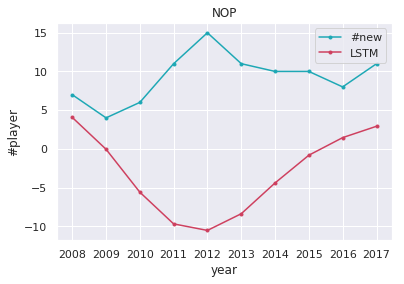

(53, 5, 1) (8, 5, 1) (53, 1) (8, 1)
624
966


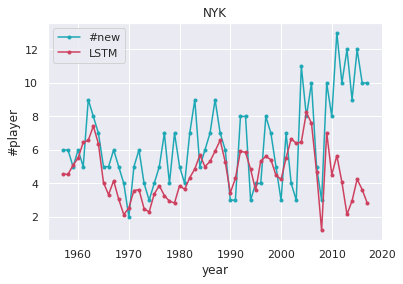

(37, 5, 1) (8, 5, 1) (37, 1) (8, 1)
732
712


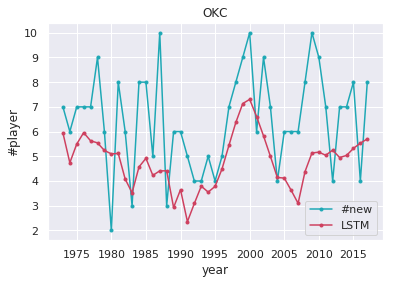

(15, 5, 1) (8, 5, 1) (15, 1) (8, 1)
640
775


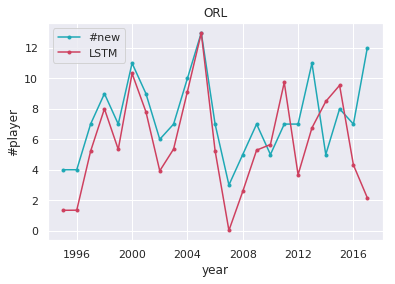

(36, 5, 1) (8, 5, 1) (36, 1) (8, 1)
480
759


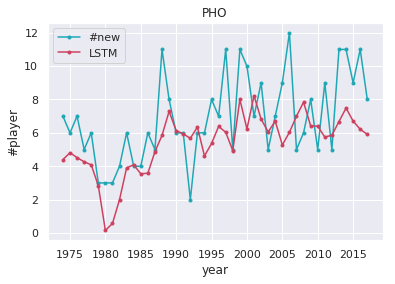

(53, 5, 1) (8, 5, 1) (53, 1) (8, 1)
877
917


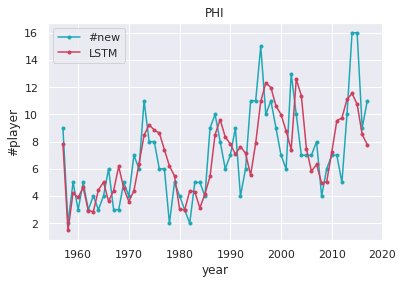

(34, 5, 1) (8, 5, 1) (34, 1) (8, 1)
999
965


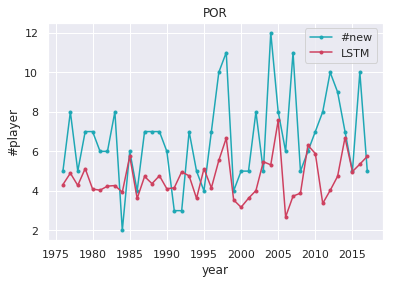

(53, 5, 1) (8, 5, 1) (53, 1) (8, 1)
128
996


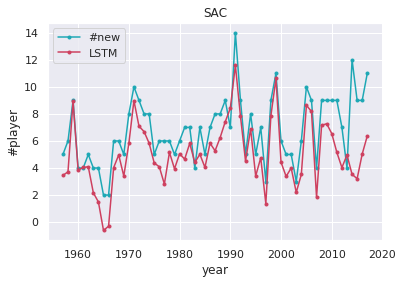

(28, 5, 1) (8, 5, 1) (28, 1) (8, 1)
762
860


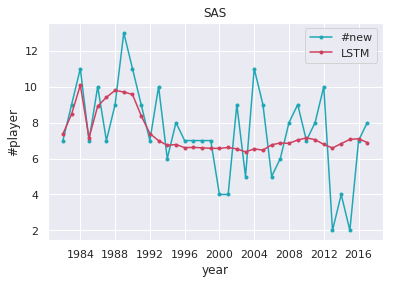

(9, 5, 1) (8, 5, 1) (9, 1) (8, 1)
4
918


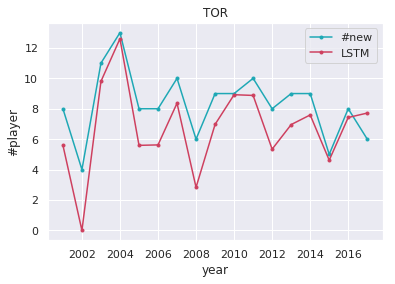

(30, 5, 1) (8, 5, 1) (30, 1) (8, 1)
393
746


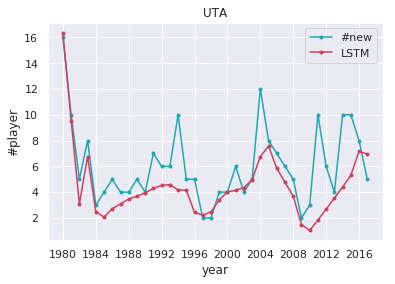

(43, 5, 1) (8, 5, 1) (43, 1) (8, 1)
881
792


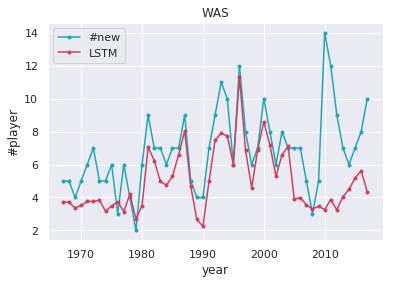

MAE 3.7954542669157187
MSE 26.289456016695432
RMSE 5.127324450109962


In [8]:
# 2010 - 2017に出現するノード数を予測

x = "year"
target = [i for i in range(2010, 2018)] # 予測期間
years = [i for i in range(1952, 2018)] # 比較用

team_ls = []
pred_ls = []
true_ls = []
for tm, graph in graph_tm.items():

    # 比較用 x軸：years_2, y軸：new_player_1
    y1 = "#new"
    new_player_1 = []
    years_2 = [] # チームが存在する年のみ扱う(全体)
    for year in years:
        diff = new_node(graph[year-1], graph[year])
        if diff != 0:
            new_player_1.append(float(diff))
            years_2.append(datetime.datetime(year, 1, 1))
    
    # LSTM
    y2 = "LSTM"
    
    #正規化
    sclr = MinMaxScaler(feature_range=(0, 1))
    data = sclr.fit_transform(np.array(new_player_1).reshape(-1, 1))
    
    #変換
    ws = 5
    X_d_c, y_d_c = convert(data, ws, 1)
    
    # データの分割
    X_train_c = X_d_c[ : X_d_c.shape[0] - len(target)]
    y_train_c = y_d_c[ : y_d_c.shape[0] - len(target)]
    X_val_c = X_d_c[X_d_c.shape[0] - len(target) : ]
    y_val_c = y_d_c[y_d_c.shape[0] - len(target) : ]
    
    print(X_train_c.shape, X_val_c.shape, y_train_c.shape, y_val_c.shape)
    
    # fit 
    lstm = Lstm(X_train_c, X_val_c, y_train_c, y_val_c)
    
    # 予測 (予測期間は2010から2017であるが、確認用として全ての年にモデルを適用)
    #予測結果で予測
    pred = predict(lstm, X_train_c, X_val_c)
    pred = pred * max(new_player_1)

    # グラフ描画
    history = {x:years_2[ws:], y1:new_player_1[ws:], y2:pred}
    plot_history2(history, x, y1, y2, title=tm, ylabel="#player")
    
    for i in range(len(target)):
        true_ls.append(new_player_1[-1-i])        
        pred_ls.append(list(pred)[-1-i])
        team_ls.append(tm)

print("MAE", mean_absolute_error(true_ls, pred_ls))
print("MSE", mean_squared_error(true_ls, pred_ls))
print("RMSE", np.sqrt(mean_squared_error(true_ls, pred_ls)))

result = pd.DataFrame({'team' : team_ls, 'true' : true_ls, 'pred' : pred_ls})
result = result.set_index('team')
result.to_csv(outputDir + "/1/LSTM/LSTM.csv")

(53, 5, 1) (8, 5, 1) (53, 1) (8, 1)
469
973


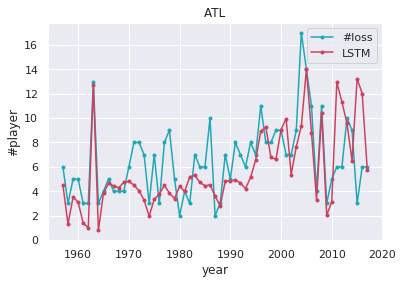

(27, 5, 1) (8, 5, 1) (27, 1) (8, 1)
784
969


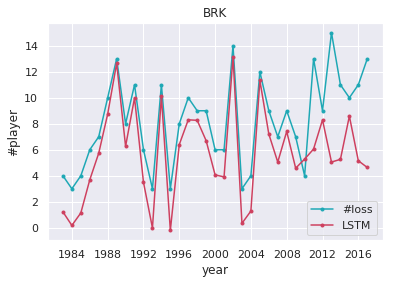

(53, 5, 1) (8, 5, 1) (53, 1) (8, 1)
943
997


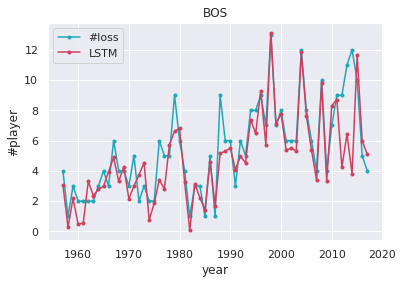

(13, 5, 1) (8, 5, 1) (13, 1) (8, 1)
286
551


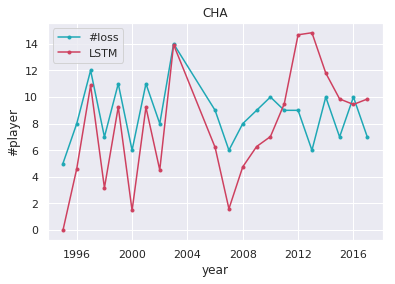

(37, 5, 1) (8, 5, 1) (37, 1) (8, 1)
995
982


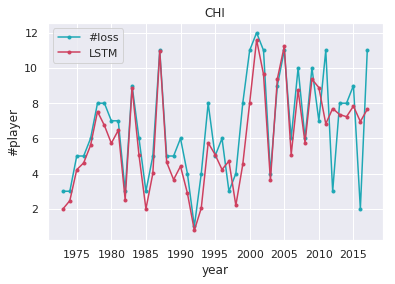

(33, 5, 1) (8, 5, 1) (33, 1) (8, 1)
662
992


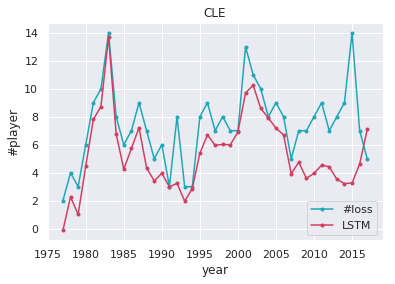

(23, 5, 1) (8, 5, 1) (23, 1) (8, 1)
90
979


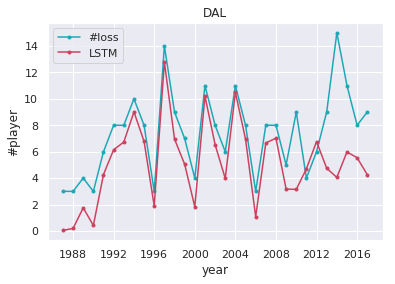

(27, 5, 1) (8, 5, 1) (27, 1) (8, 1)
601
585


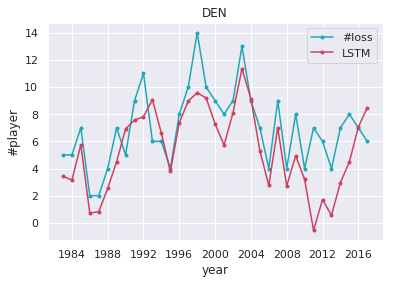

(53, 5, 1) (8, 5, 1) (53, 1) (8, 1)
874
973


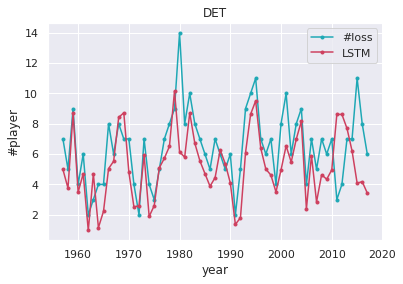

(53, 5, 1) (8, 5, 1) (53, 1) (8, 1)
710
704


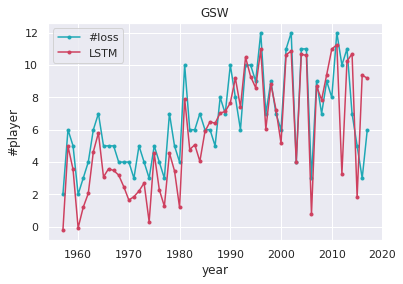

(36, 5, 1) (8, 5, 1) (36, 1) (8, 1)
820
961


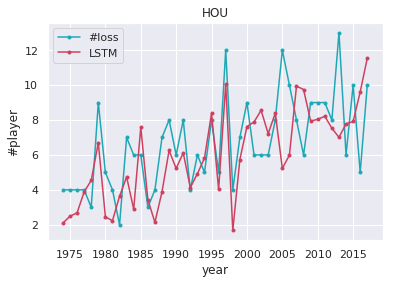

(27, 5, 1) (8, 5, 1) (27, 1) (8, 1)
614
952


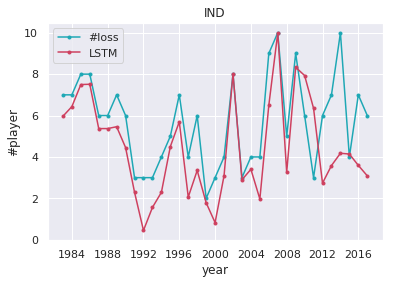

(33, 5, 1) (8, 5, 1) (33, 1) (8, 1)
614
838


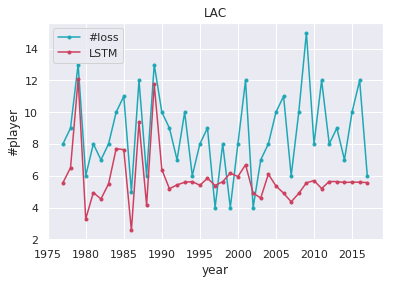

(53, 5, 1) (8, 5, 1) (53, 1) (8, 1)
994
983


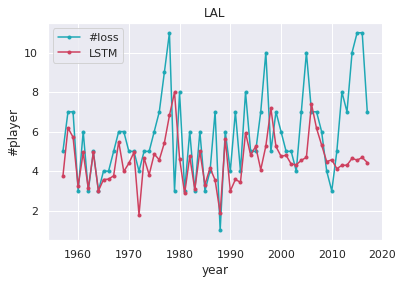

(8, 5, 1) (8, 5, 1) (8, 1) (8, 1)
7
896


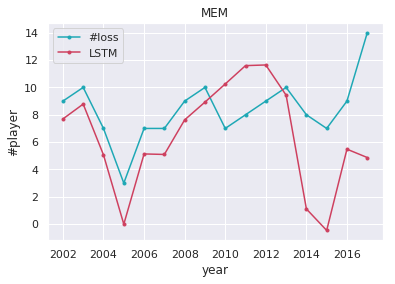

(15, 5, 1) (8, 5, 1) (15, 1) (8, 1)
2
999


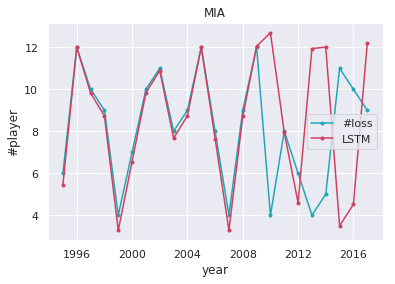

(35, 5, 1) (8, 5, 1) (35, 1) (8, 1)
372
970


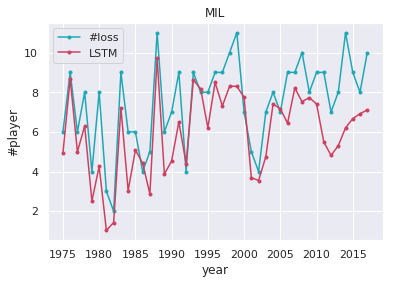

(14, 5, 1) (8, 5, 1) (14, 1) (8, 1)
485
909


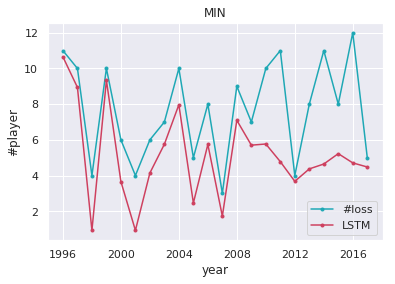

(1, 5, 1) (8, 5, 1) (1, 1) (8, 1)
8
999


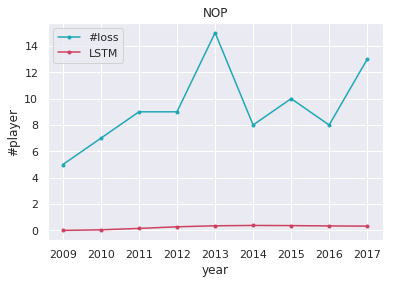

(53, 5, 1) (8, 5, 1) (53, 1) (8, 1)
0
935


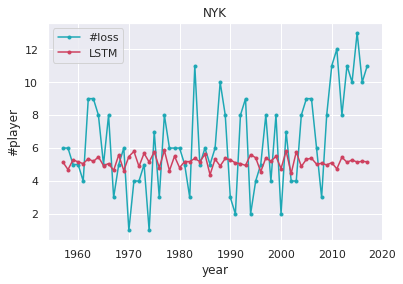

(36, 5, 1) (8, 5, 1) (36, 1) (8, 1)
550
998


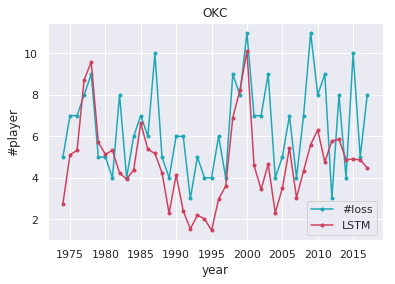

(14, 5, 1) (8, 5, 1) (14, 1) (8, 1)
4
989


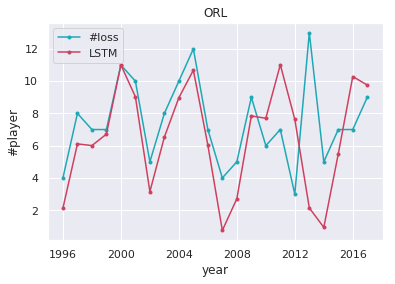

(35, 5, 1) (8, 5, 1) (35, 1) (8, 1)
415
898


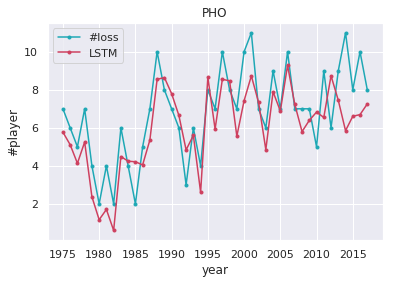

(53, 5, 1) (8, 5, 1) (53, 1) (8, 1)
833
940


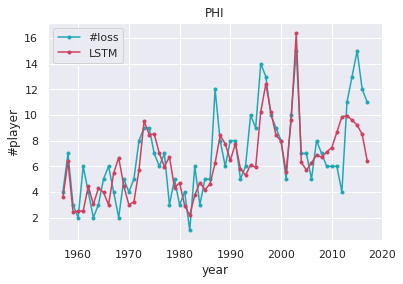

(33, 5, 1) (8, 5, 1) (33, 1) (8, 1)
903
816


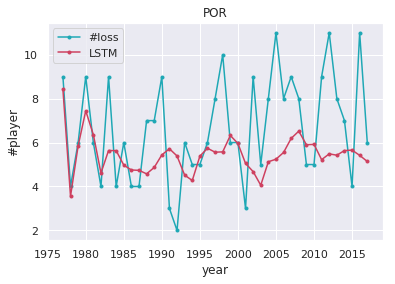

(53, 5, 1) (8, 5, 1) (53, 1) (8, 1)
892
795


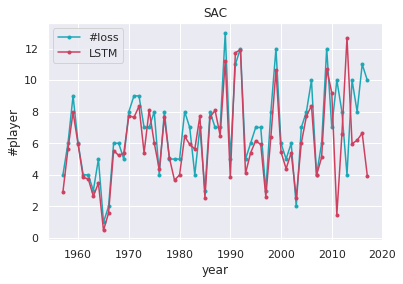

(27, 5, 1) (8, 5, 1) (27, 1) (8, 1)
937
999


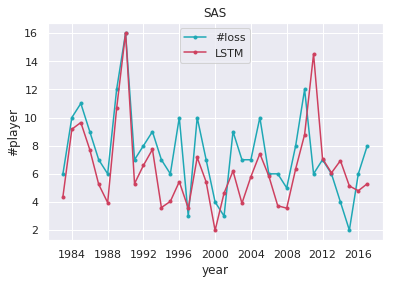

(8, 5, 1) (8, 5, 1) (8, 1) (8, 1)
4
994


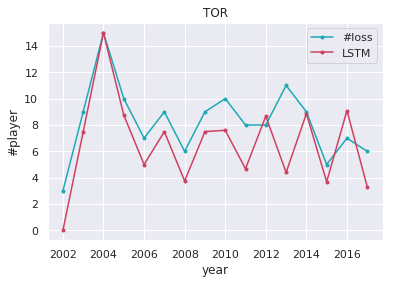

(29, 5, 1) (8, 5, 1) (29, 1) (8, 1)
158
994


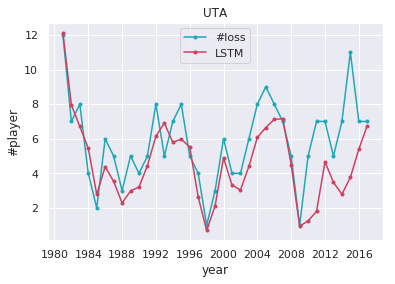

(42, 5, 1) (8, 5, 1) (42, 1) (8, 1)
802
910


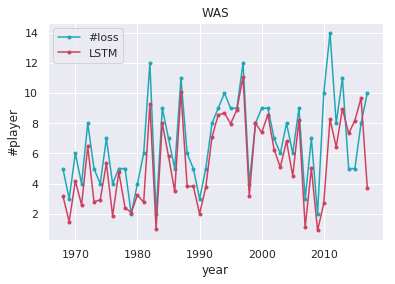

MAE 3.7653393054322803
MSE 21.42082224597941
RMSE 4.628263415794245


In [9]:
# 2010 - 2017に消失するノード数を予測

x = "year"
target = [i for i in range(2010, 2018)] # 予測期間
years = [i for i in range(1952, 2018)] # 比較用

team_ls = []
pred_ls = []
true_ls = []
for tm, graph in graph_tm.items():

    # 比較用 x軸：years_2, y軸：loss_player_1
    y1 = "#loss"
    loss_player_1 = []
    years_2 = [] # チームが存在する年のみ扱う(全体)
    for year in years:
        diff = loss_node(graph[year-1], graph[year])
        if diff != 0:
            loss_player_1.append(float(diff))
            years_2.append(datetime.datetime(year, 1, 1))
    
    # LSTM
    y2 = "LSTM"
    
    #正規化
    sclr = MinMaxScaler(feature_range=(0, 1))
    data = sclr.fit_transform(np.array(loss_player_1).reshape(-1, 1))
    
    #変換
    ws = 5
    X_d_c, y_d_c = convert(data, ws, 1)
    
    # データの分割
    X_train_c = X_d_c[ : X_d_c.shape[0] - len(target)]
    y_train_c = y_d_c[ : y_d_c.shape[0] - len(target)]
    X_val_c = X_d_c[X_d_c.shape[0] - len(target) : ]
    y_val_c = y_d_c[y_d_c.shape[0] - len(target) : ]
    
    print(X_train_c.shape, X_val_c.shape, y_train_c.shape, y_val_c.shape)
    
    # fit 
    lstm = Lstm(X_train_c, X_val_c, y_train_c, y_val_c)
    
    # 予測 (予測期間は2010から2017であるが、確認用として全ての年にモデルを適用)
    #予測結果で予測
    pred = predict(lstm, X_train_c, X_val_c)
    pred = pred * max(loss_player_1)

    # グラフ描画
    history = {x:years_2[ws:], y1:loss_player_1[ws:], y2:pred}
    plot_history2(history, x, y1, y2, title=tm, ylabel="#player")
    
    for i in range(len(target)):
        true_ls.append(loss_player_1[-1-i])        
        pred_ls.append(list(pred)[-1-i])
        team_ls.append(tm)

print("MAE", mean_absolute_error(true_ls, pred_ls))
print("MSE", mean_squared_error(true_ls, pred_ls))
print("RMSE", np.sqrt(mean_squared_error(true_ls, pred_ls)))

result = pd.DataFrame({'team' : team_ls, 'true' : true_ls, 'pred' : pred_ls})
result = result.set_index('team')
result.to_csv(outputDir + "/2/LSTM/LSTM.csv")